**Машинное обучени для текстов. Проект для «Викишоп»**
_____
**Описание исследования.**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других.

_____
**Цель исследования.**

Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Задачи исследования.**

- Обучить модель классифицировать комментарии на позитивные и негативные.

- Построить модель со значением метрики качества F1 не меньше 0.75.
    

_____
**Исходные данные.**

В распоряжении набор данных `toxic_comments.csv` с разметкой о токсичности правок.

- `text` содержит текст комментария.
- `toxic` — целевой признак.
_____
**Содержание проекта.**

***Загрузка данных:***
* [Загрузка библиотек.](#1-bullet)
* [Изученеие файла с данными, получение общей информации.](#2-bullet)

***Исследовательский анализ и предобработка***
* [Проверка на пропуски и дубли](#3-bullet)
* [Проверка дисбаланса классов](#4-bullet)
* [Нормализация и лемматизация текстов](#5-bullet)
* [Деление на тестовую и тренировочную выборки](#6-bullet)

***Обучение моделей***
* [Логистическа регрессия](#7-bullet)
* [Дерево решений](#8-bullet)
* [Лучшая модель](#9-bullet)

***Общий вывод***



## 1. Загрузка данных:

### Загрузка библиотек
<a id='1-bullet'></a>

In [ ]:
import re
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

### Изученеие файла с данными, получение общей информации
<a id='2-bullet'></a>

In [ ]:
paths = [
    '/content',
    '/datasets',
    '/Users/admin/data'
]

for path in paths:
    file_path = f'{path}/toxic_comments.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        break

pd.set_option('display.max_colwidth', None)

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0


**Вывод:**

Столбец `Unnamed: 0` совпадает с индексацией, его можно удалить

In [ ]:
df = df.drop(['Unnamed: 0'], axis=1)

## 2. Исследовательский анализ и предобработка

### Проверка на пропуски и дубли
<a id='3-bullet'></a>

In [ ]:
print('Кол-во пропусков:\n', df.isna().sum())
print('Кол-во дубликатов:', df.duplicated().sum())

Кол-во пропусков:
 text     0
toxic    0
dtype: int64
Кол-во дубликатов: 0


### Проверка дисбаланса классов
<a id='4-bullet'></a>

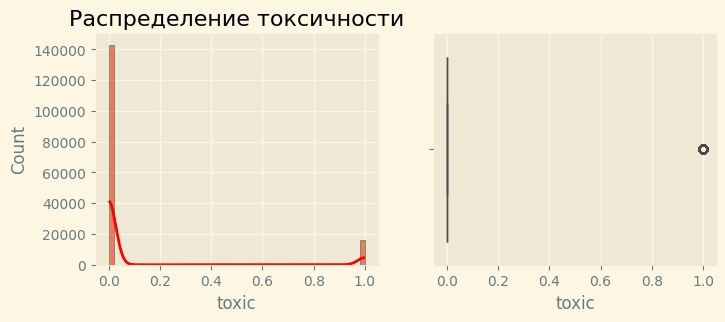

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
plt.style.use('Solarize_Light2')

plt.figure(figsize=(8,  3))
#Гистограмма
plt.subplot(1,  2,  1)
sns.histplot(df['toxic'], kde=True, color='red', edgecolor='green', bins=50)
plt.title(f'Распределение токсичности')

#Построение ящика
plt.subplot(1,  2,  2)
sns.boxplot(df['toxic'], orient="h")
plt.setp(plt.gca(),  'yticklabels', [])

plt.show()
display(df['toxic'].describe())

**Вывод:**

Наибольшее кол-во отзывов положительные. Необходимо делать балансировку классов в параметрах моделей при обучении.

### Нормализация и лемматизация текстов
<a id='5-bullet'></a>

In [ ]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

In [ ]:
def preprocessing(text):

    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    tokens = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
              for word, tag in pos_tag(word_tokenize(text))]
    text = ' '.join(tokens)
    return text

df['lemm_text'] = df['text'].progress_apply(preprocessing)

df.head(3)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...


In [ ]:
copy = df.copy()

df = df.drop(['text'], axis = 1)

### Деление на тестовую и тренировочную выборки
<a id='6-bullet'></a>

In [ ]:
y = df['toxic']
X = df.drop(['toxic'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, stratify=y)

## 3. Обучение моделей

In [ ]:
def education(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])

    grid = GridSearchCV(pipeline,
                        param_grid = params,
                        cv = 3,
                        n_jobs = -1,
                        scoring = 'f1',
                        verbose = False)

    grid.fit(X_train['lemm_text'], y_train)

    print(f'Лучший результат {model}:', grid.best_score_)
    print(f'Лучшие параметры:', grid.best_params_)

    return grid

### Логистическа регрессия
<a id='7-bullet'></a>

In [ ]:
lr = education(
    LogisticRegression(),
    {   'model__class_weight': ['balanced'],
        'model__C':[0.25, 5, 10]
    }
)

Лучший результат LogisticRegression(): 0.7684971961960155
Лучшие параметры: {'model__C': 10, 'model__class_weight': 'balanced'}


### Дерево решений
<a id='8-bullet'></a>

In [ ]:
rm = education(
    DecisionTreeClassifier(),
    {
        'model__class_weight': ['balanced'],
        'model__max_depth': [3, 6, 12]#,
        #'model__min_samples_split': [5, 15, 35],
        #'model__min_samples_leaf': [5, 25, 75]
    }
)

Лучший результат DecisionTreeClassifier(): 0.46521345448599555
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 12}


**Вывод:**

Лучший результат на тестовой выборке показала модель Регрессии

### Лучшая модель  
<a id='9-bullet'></a>

In [ ]:
y_pred = lr.predict(X_test['lemm_text'])

print('Результат LogisticRegression', f1_score(y_test, y_pred).round(3))

Результат LogisticRegression 0.765


## Общий вывод

В проекте были обучены модели с подбором гиперпатраметров для Логистической регрессии и дерева решений
По результатам оценки на тренировочной выборке лучшей оказалась модель регрессии, показавшая приемлемый результат и на тренировочной выборке